<a href="https://colab.research.google.com/github/KoreTane/interesting/blob/main/ClusterC_2024_12_21_00_45_48_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yellowbrick

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import FloatType
from ipywidgets import interact, IntSlider
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

spark = SparkSession.builder.appName("ClusterCompras").getOrCreate()

df = spark.read.csv("online.csv", header=True, inferSchema=True)
df.printSchema()
df.describe().show(truncate=False)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice           |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |1067371           |1067371           |1062989                            |1067371           |1067371           |824364            |1067371    |
|mean   |537608.1499316233 |29011.161534536903|21848.

In [3]:
df = df.fillna({'Description': 'No description'})
df = df.fillna({'Customer ID': -1})

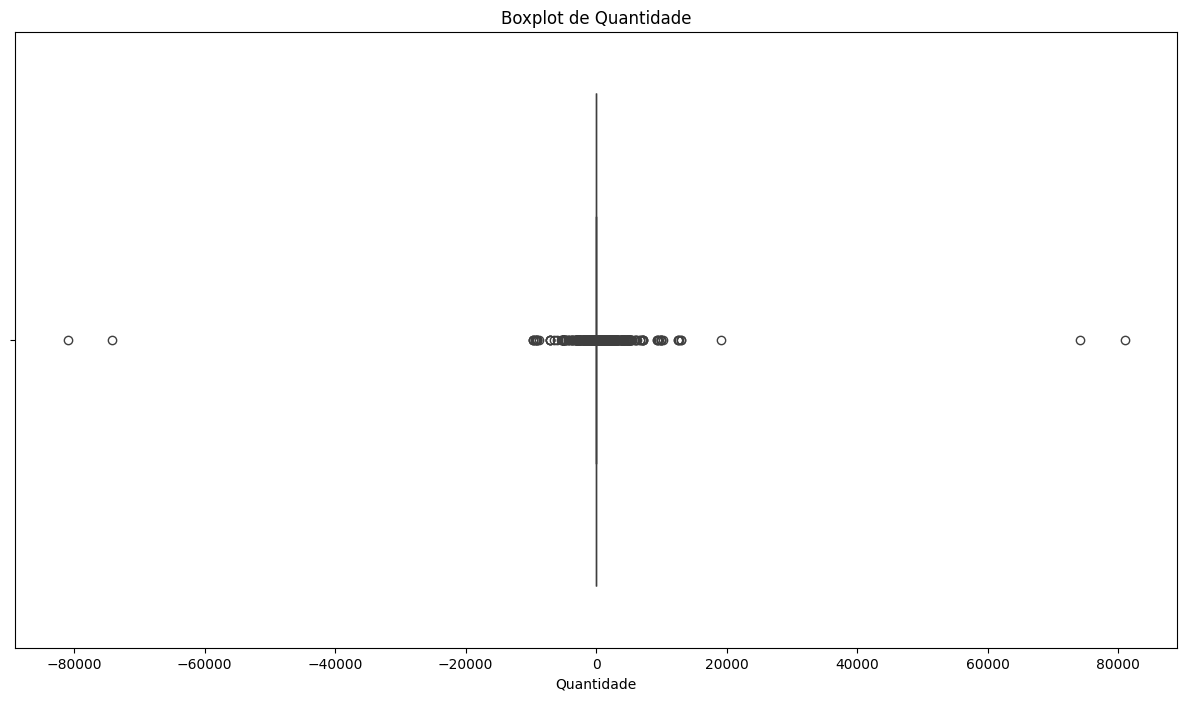

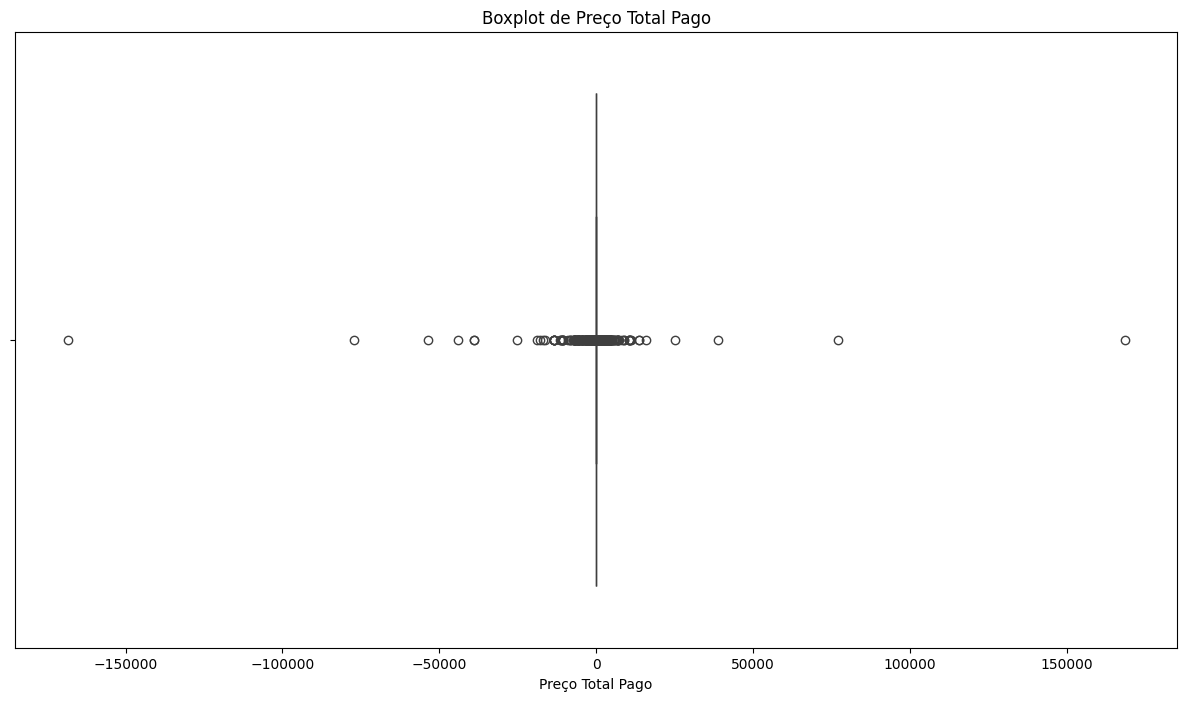

In [4]:
# os dados estão concentrados próximos a média vamos explorar os outliers
df = df.withColumn("TotalPrice", col("Quantity") * col("Price"))
quantity_pd = df.select("Quantity").toPandas()
price_pd = df.select("Price").toPandas()
total_price_pd = df.select("TotalPrice").toPandas()

# Boxplot de Quantidade
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_pd["Quantity"])
plt.title("Boxplot de Quantidade")
plt.xlabel("Quantidade")
plt.show()

# Boxplot de Preço Total Pago
plt.figure(figsize=(15, 8))
sns.boxplot(x=total_price_pd["TotalPrice"])
plt.title("Boxplot de Preço Total Pago")
plt.xlabel("Preço Total Pago")
plt.show()

In [5]:
# Os outliears são principalmente provenientes de extornos e de compras anteriores ao período considerado, podemos E L I M I N A L O S para essa análisae

quantity_greater_20000 = df.filter(col("Quantity") > 10000).count()
quantity_less_20000 = df.filter(col("Quantity") < -10000).count()
price_greater_20000 = df.filter(col("TotalPrice") > 15000).count()
price_less_20000 = df.filter(col("TotalPrice") < -15000).count()

print("Quantidade de valores em Quantity > 20000:", quantity_greater_20000)
print("Quantidade de valores em Quantity < -20000:", quantity_less_20000)
print("Quantidade de valores em Price > 20000:", price_greater_20000)
print("Quantidade de valores em Price < -20000:", price_less_20000)

df = df.filter((col("Quantity") <= 15000) & (col("Quantity") >= -15000))

df = df.filter((col("TotalPrice") <= 12000) & (col("TotalPrice") >= -12000))

Quantidade de valores em Quantity > 20000: 9
Quantidade de valores em Quantity < -20000: 2
Quantidade de valores em Price > 20000: 5
Quantidade de valores em Price < -20000: 11


In [6]:
df.describe().show(truncate=False)

+-------+------------------+------------------+-----------------------------------+-----------------+-----------------+-----------------+-----------+------------------+
|summary|Invoice           |StockCode         |Description                        |Quantity         |Price            |Customer ID      |Country    |TotalPrice        |
+-------+------------------+------------------+-----------------------------------+-----------------+-----------------+-----------------+-----------+------------------+
|count  |1067346           |1067346           |1067346                            |1067346          |1067346          |1067346          |1067346    |1067346           |
|mean   |537608.1545230626 |29011.124352999337|21848.25                           |9.912367685830088|4.526215021180736|11835.620675957  |NULL       |18.297899751348837|
|stddev |26662.471120772672|18822.91995283087 |922.9197780233488                  |82.398745415474  |64.88340965153586|6597.247365455325|NULL       |91.873

In [7]:
df.groupBy(year("InvoiceDate").alias("Ano")).count().orderBy("count", ascending=False).show()

df.groupBy(month("InvoiceDate").alias("Mês")).count().orderBy("count", ascending=False).show()

df.groupBy(dayofmonth("InvoiceDate").alias("Dia")).count().orderBy("count", ascending=False).show()

df.groupBy("Country").count().orderBy("count", ascending=False).show()

df.groupBy("StockCode", "Description").agg(sum("Quantity").alias("TotalQuantity"), sum("Price").alias("TotalPrice")).orderBy("TotalQuantity", ascending=False).show()

df.groupBy("Customer ID").agg(countDistinct("Invoice").alias("TotalOrders"), sum("Price").alias("TotalSpent")).orderBy("TotalSpent", ascending=False).show()

correlation = df.select("Quantity", "TotalPrice").corr("Quantity", "TotalPrice")
print("Correlação entre Quantity e TotalPrice:", correlation)


+----+------+
| Ano| count|
+----+------+
|2010|522698|
|2011|499420|
|2009| 45228|
+----+------+

+---+------+
|Mês| count|
+---+------+
| 11|162725|
| 12|135747|
| 10|119839|
|  9| 92317|
|  3| 78259|
|  6| 76853|
|  7| 72900|
|  5| 72353|
|  8| 68589|
|  1| 66698|
|  4| 63972|
|  2| 57094|
+---+------+

+---+-----+
|Dia|count|
+---+-----+
|  7|47297|
|  8|45961|
|  6|40336|
| 17|39267|
|  5|39018|
| 18|38334|
| 14|37760|
|  4|37246|
|  1|37236|
| 21|37159|
| 11|37075|
| 10|36573|
|  9|36389|
| 28|35050|
| 22|35006|
| 15|33866|
| 25|33823|
| 16|33726|
|  2|32997|
| 13|32782|
+---+-----+
only showing top 20 rows

+---------------+------+
|        Country| count|
+---------------+------+
| United Kingdom|981306|
|           EIRE| 17866|
|        Germany| 17624|
|         France| 14330|
|    Netherlands|  5140|
|          Spain|  3811|
|    Switzerland|  3189|
|        Belgium|  3123|
|       Portugal|  2620|
|      Australia|  1913|
|Channel Islands|  1664|
|          Italy|  1534|
|  

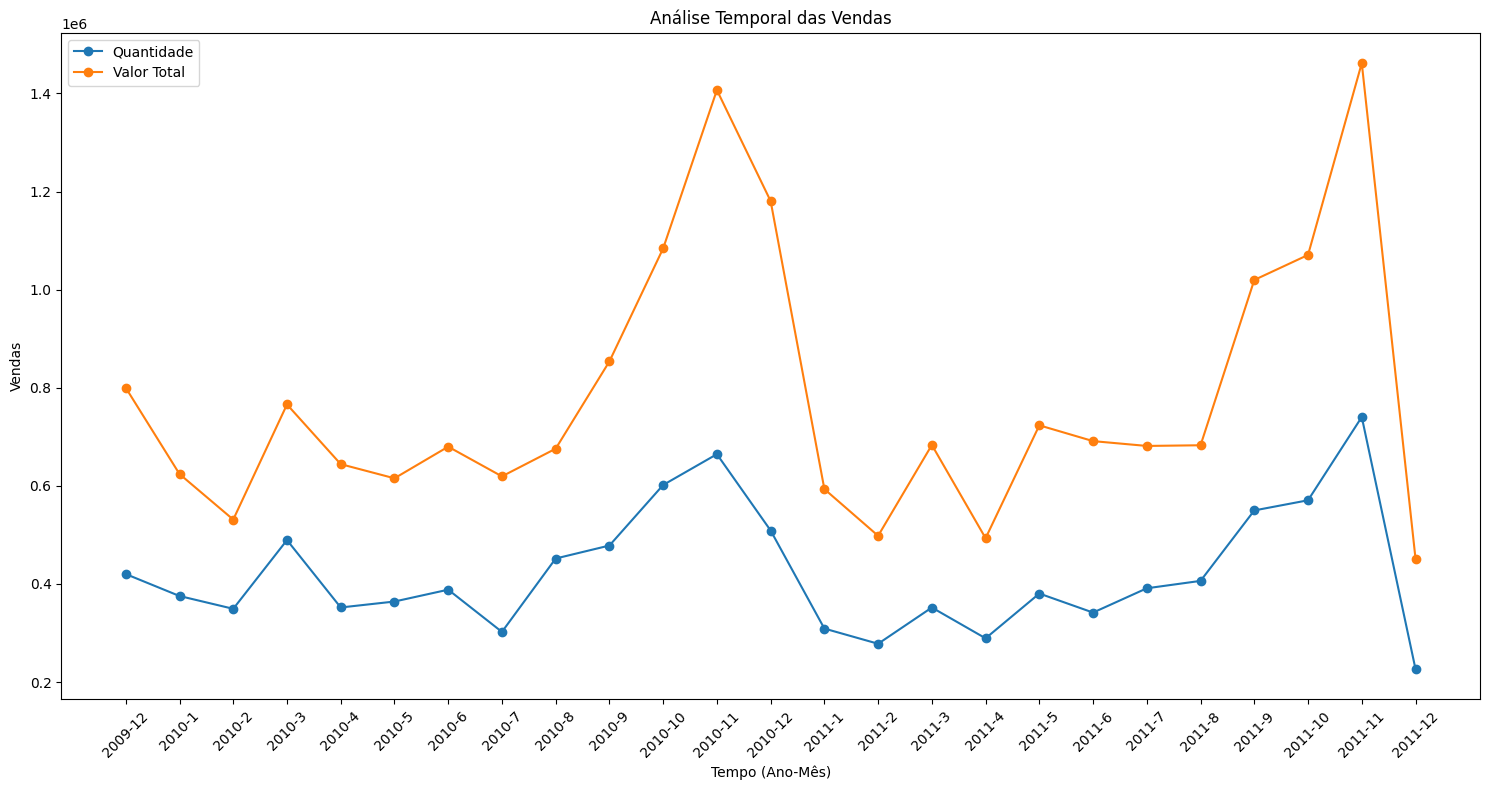

In [8]:
# oaumento significativo de consumo sazonal das festividades de fim de ano. Há uma queda no inicio do verão, se deve em parte por ser um período de férias que consumidor efetua a compra presencial
temporal_df = df.withColumn("Year", year("InvoiceDate")).withColumn("Month", month("InvoiceDate"))
temporal_agg_df = temporal_df.groupBy("Year", "Month").agg(sum("Quantity").alias("TotalQuantity"), sum(expr("Quantity * Price")).alias("TotalValue")).orderBy("Year", "Month")
temporal_agg_pd = temporal_agg_df.toPandas()

plt.figure(figsize=(15, 8))

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalQuantity"], label="Quantidade", marker='o')

plt.plot(temporal_agg_pd["Year"].astype(str) + '-' + temporal_agg_pd["Month"].astype(str), temporal_agg_pd["TotalValue"], label="Valor Total", marker='o')

plt.title("Análise Temporal das Vendas")
plt.xlabel("Tempo (Ano-Mês)")
plt.ylabel("Vendas")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# quem compra PINK REGENCY TEACUP AND SAUCER e ROSES REGENCY TEACUP AND SAUCER também compra GREEN REGENCY TEACUP AND SAUCER
df = df.withColumn("TotalSpent", col("Quantity") * col("Price"))

# Adicionar colunas de data
df = df.withColumn("DayOfWeek", dayofweek("InvoiceDate"))
df = df.withColumn("HourOfDay", hour("InvoiceDate"))

# Calcular RFM
recency_df = df.groupBy("Customer ID").agg(datediff(current_date(), max("InvoiceDate")).alias("Recency"))
frequency_df = df.groupBy("Customer ID").agg(count("Invoice").alias("Frequency"))
monetary_df = df.groupBy("Customer ID").agg(sum("TotalPrice").alias("Monetary"))

# Juntar RFM
rfm_df = recency_df.join(frequency_df, "Customer ID").join(monetary_df, "Customer ID")

# Calcular novas características
avg_spent_per_purchase_df = df.groupBy("Customer ID").agg((sum("TotalPrice") / countDistinct("Invoice")).alias("AvgSpentPerPurchase"))
variety_of_products_df = df.groupBy("Customer ID").agg(countDistinct("StockCode").alias("VarietyOfProducts"))

# Juntar novas características ao DataFrame RFM
feature_df = rfm_df.join(avg_spent_per_purchase_df, "Customer ID").join(variety_of_products_df, "Customer ID")

# Ordenar por Monetary em ordem decrescente
feature_df = feature_df.orderBy(col("Monetary").desc())

# Exibir características aprimoradas
feature_df.show()

# Análise de Cohorts
cohort_df = df.groupBy("Customer ID").agg(min("InvoiceDate").alias("CohortDate"))
cohort_df = cohort_df.withColumn("CohortYear", year("CohortDate")).withColumn("CohortMonth", month("CohortDate"))

# Exibir Cohorts
cohort_df.show()

# Preparar dados para análise de cesta, garantindo que itens sejam únicos em cada transação
basket_data = df.groupBy("Invoice").agg(collect_set("StockCode").alias("Items"))

# Aplicar algoritmo FPGrowth
fpgrowth = FPGrowth(itemsCol="Items", minSupport=0.01, minConfidence=0.01)
model = fpgrowth.fit(basket_data)

model.freqItemsets.orderBy(col("freq").desc()).show(truncate=False)

model.associationRules.orderBy(col("confidence").desc()).show(truncate=False)


+-----------+-------+---------+------------------+-------------------+-----------------+
|Customer ID|Recency|Frequency|          Monetary|AvgSpentPerPurchase|VarietyOfProducts|
+-----------+-------+---------+------------------+-------------------+-----------------+
|       -1.0|   4762|   242991|2874520.2299997695|  328.8924748283742|             5177|
|    18102.0|   4762|     1068| 598215.2200000001|  3909.903398692811|              384|
|    14646.0|   4763|     3890| 523342.0700000004|  3191.110182926829|              964|
|    14156.0|   4771|     4130|296564.69000000024| 1468.1420297029704|             1446|
|    14911.0|   4763|    11613|  270248.529999999|  529.8990784313723|             2557|
|    17450.0|   4770|      448|233579.39000000013| 3829.1703278688524|              148|
|    13694.0|   4765|     1558|190825.52000000016| 1163.5702439024394|              902|
|    17511.0|   4764|     2134| 171885.9799999999| 2022.1879999999994|              678|
|    12415.0|   4786|

In [10]:
# Filtrar outliers com base em um limite para "Monetary"
quantile_99 = feature_df.approxQuantile("Monetary", [0.97], 0.01)[0]
filtered_df = feature_df.filter(feature_df.Monetary < quantile_99)

# Combine as colunas em um vetor temporário para a normalização
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary", "AvgSpentPerPurchase", "VarietyOfProducts"], outputCol="temp_features")
temp_features = assembler.transform(filtered_df)

# Normalizar as características
scaler = StandardScaler(inputCol="temp_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(temp_features)
scaled_data = scaler_model.transform(temp_features)

# Função para extrair elementos do vetor
def extract_element(v, i):
    try:
        return float(v[i])
    except IndexError:
        return None

extract_element_udf = udf(extract_element, FloatType())

# Aplicar a UDF para criar colunas separadas
scaled_data = scaled_data.withColumn("scaledRecency", extract_element_udf(col("scaled_features"), lit(0))) \
                         .withColumn("scaledFrequency", extract_element_udf(col("scaled_features"), lit(1))) \
                         .withColumn("scaledMonetary", extract_element_udf(col("scaled_features"), lit(2))) \
                         .withColumn("scaledAvgSpentPerPurchase", extract_element_udf(col("scaled_features"), lit(3))) \
                         .withColumn("scaledVarietyOfProducts", extract_element_udf(col("scaled_features"), lit(4)))

# Tratar valores NaN substituindo por zero
scaled_data = scaled_data.withColumn("scaledRecency", when(col("scaledRecency").isNull(), 0).otherwise(col("scaledRecency"))) \
                         .withColumn("scaledFrequency", when(col("scaledFrequency").isNull(), 0).otherwise(col("scaledFrequency"))) \
                         .withColumn("scaledMonetary", when(col("scaledMonetary").isNull(), 0).otherwise(col("scaledMonetary"))) \
                         .withColumn("scaledAvgSpentPerPurchase", when(col("scaledAvgSpentPerPurchase").isNull(), 0).otherwise(col("scaledAvgSpentPerPurchase"))) \
                         .withColumn("scaledVarietyOfProducts", when(col("scaledVarietyOfProducts").isNull(), 0).otherwise(col("scaledVarietyOfProducts")))

# Verificar se há valores nulos
scaled_data = scaled_data.na.drop()

# Manter apenas a coluna features para o K-Means
assembler = VectorAssembler(inputCols=["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledAvgSpentPerPurchase", "scaledVarietyOfProducts"], outputCol="features")
final_df = assembler.transform(scaled_data).select("features")

In [11]:
# Definir o número de clusters
k = 4

# Aplicar K-Means
kmeans = KMeans(k=k, seed=1)
model = kmeans.fit(final_df)
clusters = model.transform(final_df)

# Converter para Pandas para plotagem
clusters_pd = clusters.select("features", "prediction").toPandas()

# Extrair as colunas separadas de features
features_df = clusters_pd["features"].apply(pd.Series)
features_df.columns = ["scaledRecency", "scaledFrequency", "scaledMonetary", "scaledAvgSpentPerPurchase", "scaledVarietyOfProducts"]
clusters_pd = pd.concat([features_df, clusters_pd["prediction"]], axis=1)

# Plotar os clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=clusters_pd, x="scaledRecency", y="scaledMonetary", hue="prediction", palette="Set1")
plt.title(f'Clusters com k={k}')
plt.xlabel('Recency (Normalizado)')
plt.ylabel('Monetary (Normalizado)')
plt.legend(title='Cluster')
plt.show()

Py4JJavaError: An error occurred while calling o602.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 238.0 failed 1 times, most recent failure: Lost task 0.0 in stage 238.0 (TID 193) (9ce00448b11e executor driver): org.apache.spark.SparkRuntimeException: Error while decoding: java.lang.NullPointerException
newInstance(class org.apache.spark.ml.linalg.VectorUDT).deserialize.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.expressionDecodingError(QueryExecutionErrors.scala:1406)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder$Deserializer.apply(ExpressionEncoder.scala:191)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.$anonfun$scalaConverter$2(ScalaUDF.scala:171)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificMutableProjection.apply(Unknown Source)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$10(EvalPythonExec.scala:127)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1161)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1176)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1214)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$PythonUDFWriterThread.writeIteratorToStream(PythonUDFRunner.scala:58)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:62)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder$Deserializer.apply(ExpressionEncoder.scala:188)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1296)
	at org.apache.spark.rdd.RDD.$anonfun$takeSample$1(RDD.scala:629)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.takeSample(RDD.scala:618)
	at org.apache.spark.mllib.clustering.KMeans.initKMeansParallel(KMeans.scala:400)
	at org.apache.spark.mllib.clustering.KMeans.runAlgorithmWithWeight(KMeans.scala:273)
	at org.apache.spark.mllib.clustering.KMeans.runWithWeight(KMeans.scala:231)
	at org.apache.spark.ml.clustering.KMeans.trainWithRow(KMeans.scala:446)
	at org.apache.spark.ml.clustering.KMeans.$anonfun$fit$1(KMeans.scala:382)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:371)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:295)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkRuntimeException: Error while decoding: java.lang.NullPointerException
newInstance(class org.apache.spark.ml.linalg.VectorUDT).deserialize.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.expressionDecodingError(QueryExecutionErrors.scala:1406)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder$Deserializer.apply(ExpressionEncoder.scala:191)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.$anonfun$scalaConverter$2(ScalaUDF.scala:171)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificMutableProjection.apply(Unknown Source)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$10(EvalPythonExec.scala:127)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1161)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1176)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1214)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$PythonUDFWriterThread.writeIteratorToStream(PythonUDFRunner.scala:58)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: java.lang.NullPointerException
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:62)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder$Deserializer.apply(ExpressionEncoder.scala:188)
	... 18 more
